Loading Libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.ensemble import RandomForestClassifier as rfclassifier
from sklearn.feature_selection import RFE 
from mordred import Calculator, descriptors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm
from rdkit import Chem
import pandas as pd
import numpy as np

First, load the full subset of QM9 available through our GitHub and create distinct subsets of 10000 for training and 2000 for testing. 

In [2]:
QM9_data_raw = pd.read_json("../../datasets/qm9.json.gz",lines=True)

subset_QM9 = QM9_data_raw.sample(12000)

Then, compute features for each using Mordred.

In [3]:
mord_calc = Calculator(descriptors,ignore_3D=True)

In [4]:
subset_QM9['mol'] = subset_QM9['smiles_0'].apply(Chem.MolFromSmiles)
feats = mord_calc.pandas(subset_QM9['mol'])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [02:30<00:00, 79.56it/s]


In [5]:
#test_data['mol'] = test_data['smiles_0'].apply(Chem.MolFromSmiles)
#test_feats = mord_calc.pandas(test_data['mol'])

You will need to convert all data to a float (see DataFrame.astype) and drop missing values, but do not use any other dimensionality reduction.

In [6]:
feats = feats.astype('float64')
#test_feats = test_feats.astype('float64')

In [7]:
missing_vals = feats.isnull().any() #found 447

In [8]:
feats = feats.loc[:, ~missing_vals]
#test_feats = test_feats.loc[:, ~missing_vals_test_feats]

In [9]:
feats.shape
#test_feats.shape

(12000, 1067)

 Once complete, make a test set of 2000 molecules (already done)


### 1. Train a LassoCV model using the features with and without reducing the dimensionality to 8 features using PCA. Plot the change in mean absolute error (MAE) with respect to training set sizes: 10, 100, 1000. How do the results compare? Why do some models continue to improve at large training set sizes while others do not?

In [10]:
train_data10,test_data10,train_feats10,test_feats10 = train_test_split(subset_QM9,feats,train_size=10)
train_data100,test_data100,train_feats100,test_feats100 = train_test_split(subset_QM9,feats,train_size=100)
train_data1000,test_data1000,train_feats1000,test_feats1000 = train_test_split(subset_QM9,feats,train_size=1000)
train_dataFull,test_dataFull,train_featsFull,test_featsFull = train_test_split(subset_QM9,feats,train_size=10000)


In [11]:
model_PCA = Pipeline([
    ('scale',StandardScaler()),
    ('pca',PCA(n_components=8)),
    ('lasso',LassoCV())
]) #faster when computing lasso, but less accurate than just Lasso itself

In [12]:
lst_of_results = ['bandgap']

In [13]:
test_dataFull = test_dataFull.copy()
test_dataFull['8-ncomp-pca-model-Full'] = model_PCA.fit(train_featsFull,train_dataFull['bandgap']).predict(test_featsFull)
test_dataFull['8-ncomp-pca-model-10'] = model_PCA.fit(train_feats10,train_data10['bandgap']).predict(test_featsFull)
test_dataFull['8-ncomp-pca-model-100'] = model_PCA.fit(train_feats100,train_data100['bandgap']).predict(test_featsFull)
test_dataFull['8-ncomp-pca-model-1000'] = model_PCA.fit(train_feats1000,train_data1000['bandgap']).predict(test_featsFull)

In [14]:
lst_of_results.extend(['8-ncomp-pca-model-10','8-ncomp-pca-model-100','8-ncomp-pca-model-1000','8-ncomp-pca-model-Full'])

In [15]:
model_nonPCA = Pipeline([
    ('scale',StandardScaler()),
    ('lasso',LassoCV(tol=0.01)) #note on tol, set to 0.01 else the convergance fails
])

In [16]:
test_dataFull['no-pca'] = model_nonPCA.fit(train_featsFull,train_dataFull['bandgap']).predict(test_featsFull)
test_dataFull['no-pca-10'] = model_nonPCA.fit(train_feats10,train_data10['bandgap']).predict(test_featsFull)
test_dataFull['no-pca-100'] = model_nonPCA.fit(train_feats100,train_data100['bandgap']).predict(test_featsFull)
test_dataFull['no-pca-1000'] = model_nonPCA.fit(train_feats1000,train_data1000['bandgap']).predict(test_featsFull)

/home/allen/software/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.32270267142092, tolerance: 0.22219841520351
  positive)
/home/allen/software/anaconda3/envs/applied-ai/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0286017726444793, tolerance: 0.0229706199324
  positive)


In [17]:
lst_of_results.extend(['no-pca-10','no-pca-100','no-pca-1000','no-pca'])

Train a RandomForest model using the default settings:

In [18]:
model_rf = Pipeline([
    ('scale',StandardScaler()),
    ('rf',rf())
])

In [19]:
test_dataFull['rf'] = model_rf.fit(train_featsFull,train_dataFull['bandgap']).predict(test_featsFull)
test_dataFull['rf10'] = model_rf.fit(train_feats10,train_data10['bandgap']).predict(test_featsFull)
test_dataFull['rf100'] = model_rf.fit(train_feats100,train_data100['bandgap']).predict(test_featsFull)
test_dataFull['rf1000'] = model_rf.fit(train_feats1000,train_data1000['bandgap']).predict(test_featsFull)
#Note: this function takes around 5~8 mins

In [20]:
lst_of_results.extend(['rf10','rf100','rf1000','rf'])

Plot the change in mean absolute error (MAE) with respect to training set sizes: 10, 100, 1000. How do the results compare?

In [21]:
MAE_lst = []

for c in lst_of_results:
    MAE_lst.append(mean_absolute_error(test_dataFull['bandgap'],test_dataFull[c]))

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

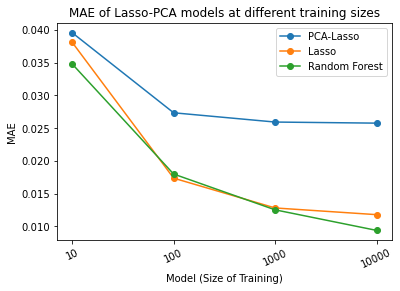

In [22]:
fig, ax = plt.subplots()

ax.plot(['10','100','1000','10000'],MAE_lst[1:5],'o-',label = 'PCA-Lasso')
ax.plot(['10','100','1000','10000'],MAE_lst[5:9],'o-',label = 'Lasso')
ax.plot(['10','100','1000','10000'],MAE_lst[9:13],'o-',label = 'Random Forest')
ax.legend()

ax.set_xlabel("Model (Size of Training)")
ax.set_ylabel("MAE")
ax.set_title("MAE of different models at different training sizes")
plt.xticks(rotation=25)

Notice that Random Forest out performs all other models at high training sizes. Furthermore the PCA-Lasso is the worst amongst the different models that we have fitted at higher training sizes. Lasso models do not improve that drasticaly relative to Random Forest models.

### 2. Rank the top features for LASSO (NO PCA) (using coefficients) and random forest (using the assigned feature scores) (Hint: np.argsort).

#### i) Compare the top 10 features with lasso and random forest (Hint: Python set logic). Are any the same? Why is this expected?

In [23]:
lasso_coefs = model_nonPCA.named_steps['lasso'].coef_

In [24]:
lasso_coefs

array([-0.        , -0.00195457,  0.00085893, ..., -0.        ,
       -0.        ,  0.        ])

In [25]:
rf_features = model_rf.named_steps['rf'].feature_importances_

In [26]:
lasso_top10 = np.argsort(lasso_coefs)[-10:]
rf_top10 = np.argsort(rf_features)[-10:]

Notice that the most imortant features selected by the two models are different. This is actually to be expected, as Lasso and RF have different ways in which features are selected. In particular, lasso selects for features linearly (as implied by a linear regression format) while RF does not pose linearity between variables as a constraint for searching, allowing for more possibilities when searching for different variables to (or to not) consider.

#### ii) Assess the correlation between top 10 features for LASSO, and then (separately) between top 10 features from random forest. What does this imply about how to interpret the most important features?

In [27]:
crosscorr_Lasso = np.corrcoef(feats.iloc[:,lasso_top10].T)
crosscorr_rf = np.corrcoef(feats.iloc[:,rf_top10].T)

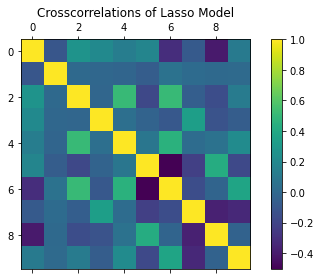

In [28]:
fig, ax = plt.subplots()

cax = ax.matshow(crosscorr_Lasso, interpolation='nearest')
fig.colorbar(cax)
ax.set_title("Crosscorrelations of Lasso Model")

fig.tight_layout()

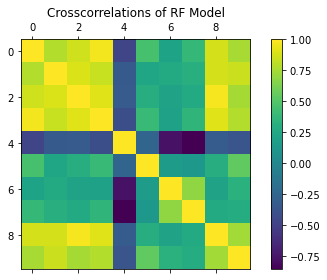

In [29]:
fig, ax = plt.subplots()

cax = ax.matshow(crosscorr_rf, interpolation='nearest')
fig.colorbar(cax)
ax.set_title("Crosscorrelations of RF Model")

fig.tight_layout()

This means that we cannot necessarily use the models that we have designed here as any sort of causal descriptor or interpret it as something that we can use to replicate experiments. Rather, we should only use these results as predictive measurements than causal descriptors of results.

#### iii) Re-fit the model another time for one of the models, on a newly sampled set of $10^4$ data points. Do the results change between runs? 

I will fit the LASSO regression again using a new sample of 10000 data points. The results are the following:

In [30]:
train_data_re,test_data_re,train_feats_re,test_feats_re = train_test_split(subset_QM9,feats,train_size=10000)

test_data_re['Lasso'] = model_nonPCA.fit(train_feats_re,train_data_re['bandgap']).predict(test_feats_re)

/home/allen/software/anaconda3/envs/applied-ai/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
lasso_coefs_re = model_nonPCA.named_steps['lasso'].coef_

lasso_top10_re = np.argsort(lasso_coefs_re)[:10]

In [33]:
set(lasso_top10_re) is set(lasso_top10)

False

Notice that the two models, despite having the same specification, does not actually get the same top features. This implies that the features from a machine learning model cannot necessarily be interpreted in a causal framework. Even if the end predicts do not vary siginificantly

### 3) Discuss the relative advantages of RandomForest versus Linear Regression versus Linear Regression with PCA.

1. Linear Regression w/ PCA: The model was able to be constructed very quickly after PCA is completed. However, the PCA will create new variables that don't necessarily have meaning (even though we are not really concerned about them anyways). Furthermore, the model does not improve with more data, and is overall (level-wise) worse in MAE than the LASSO by itself.

2. Linear Regression: The model took longer than its with-PCA counterpart. However, its MAE was globally lower than the model which included PCA. It can also be argued that it improved better relative to the with-PCA model, but not as strong as RF.

3. Random Forest (RF): This model grew in accuracy the most as we move from smaller training sets to larger training sets. However, this model took longer and was arguably more computantionally intensive (judging by Task Manager statistics), though not too intensive.

## Molecular Fingerprints

### 1. Create a training set of 1000 entries. Train a k-Nearest Neighbors (kNN) regressor model using a Jaccard distance metric based on 128-length Morgan fingerprint with a radius of 3. Plot how the performance on the model (on a test set of 2000 entries) changes as you increase the number of neighbors used in kNN from 1 to $2^7$ by a factor of 2 each time. Explain why the MAE improves when increasing from 1 and then worsens as you increase past $2^4$.

First, we need to creat a function which utilizes the BaseEstimator from scikit and use it to transform SMILEs strings into fingerprint vectors. Adapting from the applied-ai-for-materials notebook:

In [34]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    mol = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        mol, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=np.bool)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr

In [35]:
class MorganFingerprintTransform(BaseEstimator, TransformerMixin):
    """
    Class which converts SMILES strings into fingerprint vectors
    """
    
    def __init__(self, length: int=128, radius: int=3):
        self.length=length
        self.radius=radius
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Compute the fingerprint using the compute_morgan_fingerprints function
        
        inpt:
            X: (list) list of SMILES strings
        otpt:
            otpt: (np.array) Array of fingerprints for a given molecule
        """
        fing = [compute_morgan_fingerprints(mol,self.length,self.radius) for mol in X]
        otpt = np.vstack(fing)
        return otpt


In [36]:
morg = MorganFingerprintTransform()

Now that we have the code working for transforming fingerprints, I will now construct the KNN regressor. First, I will have to make a train-test-split

In [37]:
fingerprint_data = QM9_data_raw.sample(3000)

In [38]:
train_data, test_data = train_test_split(fingerprint_data,train_size=1000)

Now setting up the KNN model

In [39]:
model_knn = Pipeline([
    ('fingerprint', MorganFingerprintTransform()),
    ('knn', KNeighborsRegressor(n_neighbors=1, metric='jaccard'))
])

In [40]:
res = []

for n_neigh_exp in [0,1,2,3,4,5,6,7]:

    model_knn.set_params(knn__n_neighbors=2**n_neigh_exp)
    y_pred = model_knn.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])
    
    res.append({
        'knn_neighbors': f"2^{n_neigh_exp}",
        'mae': mean_absolute_error(test_data['bandgap'],y_pred)
    })

res_df = pd.DataFrame(res)

Now plotting the results:

Text(0.5, 1.0, 'MAE as Neighborhood Size Increases')

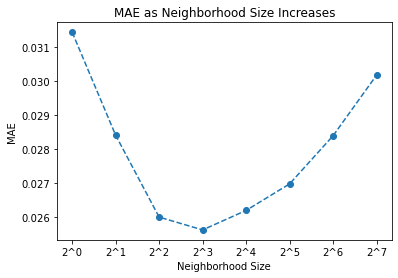

In [41]:
fig, ax = plt.subplots()

ax.plot(res_df['knn_neighbors'],res_df['mae'],'--o')

ax.set_xlabel("Neighborhood Size")
ax.set_ylabel("MAE")
ax.set_title("MAE as Neighborhood Size Increases")

Notice then, as neighborhood size increases, it does not necessarily lead to better results. This is intuitive because KNN gathers points with specific traits/fingerprints in order to make predictions using their average traits. However, if the neighborhood is too large, it could be the case where it fails to discriminate between molecules of different characteristics as it is clustered into a single neighborhood.

### 2. Add a step in the model Pipeline from Step 1 that uses Recursive Feature Elimination with a Random Forest model to reduce the number of features to 32 in 4 steps. Compare the MAE versus number of neighbors to kNN without feature selection.

In [42]:
model_knn_RFE = Pipeline([
    ('fingerprint', MorganFingerprintTransform()),
    ('RFE', RFE(rf(),n_features_to_select=32,step=4)),
    ('knn', KNeighborsRegressor(n_neighbors=1, metric='jaccard'))])

I have now built a model with the RFE step using a RandomForrestClassifier. Running the same model as before:

In [43]:
res_RFE = []

for n_neigh_exp in [0,1,2,3,4,5,6,7]:

    model_knn_RFE.set_params(knn__n_neighbors=2**n_neigh_exp)
    y_pred = model_knn_RFE.fit(train_data['smiles_0'],train_data['bandgap']).predict(test_data['smiles_0'])
    
    res_RFE.append({
        'knn_neighbors': f"2^{n_neigh_exp}",
        'mae': mean_absolute_error(test_data['bandgap'],y_pred)
    })

res_RFE_df = pd.DataFrame(res_RFE)

Text(0.5, 1.0, 'MAE as Neighborhood Size Increases')

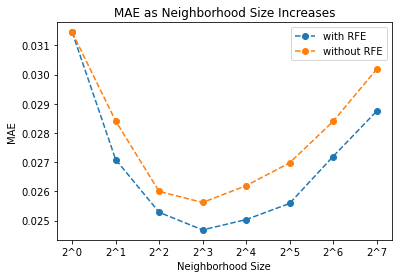

In [44]:
fig, ax = plt.subplots()

ax.plot(res_df['knn_neighbors'],res_RFE_df['mae'],'--o',label="with RFE")
ax.plot(res_df['knn_neighbors'],res_df['mae'],'--o',label="without RFE")

ax.legend()

ax.set_xlabel("Neighborhood Size")
ax.set_ylabel("MAE")
ax.set_title("MAE as Neighborhood Size Increases")

### 3. Why would the model with the feature selection perform better? In general terms, explain the disadvantage of using a general-purpose distnace metrics such as fingerprints and how must one must account for that

There are a few reasons why feature selection will out-perform a model without feature selection. In particular, KNN uses small neighborhoods within the fingerprint-space to classify and make prediction base on the average characteristics of that neighborhood. However, if there are redundant attributes in the dataset, it could be the case that these seemingly redundant attributes will skew the selection process by assigning neighborhoods that are inaccurate 

My interpretation is the following: say *all* points in neighborhood X (and ONLY neigborhood X) has feature A. At the same time, 99% of points those points within X both have feature A and B. However, there is a random distribution of points outside this neighborhood that also has feature B. 

Now let's also assume that in 'reality', neighborhood X is already well-defined (99% of all points with features A and B, and 100% of points with A). However, A general-purpose KNN model using fingerprints might pick up on the small variations within feature B and mis-estimate neighborhood X-prime to include points that lie outside the 'true' neighborhood X. Without feature selection, one can see how this small feature B could change the assignment of neighborhood X.